In [13]:
# import matplotlib as plt
import tensorflow as tf
import sklearn
# import nibabel as nib

In [14]:
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import Input,Model,Sequential
from tensorflow.keras import layers,optimizers,losses,metrics
# model=keras.Sequential()
# model.add(layers.InputLayer(input_shape=(50,42,42,1)))
def getmodel():

    #conv3d
    def Conv3D_U(channel):
        return layers.Conv3D(channel,3,padding='same')

    #BN+activate(relu)
    def BN_AC():
        return Sequential([
            layers.BatchNormalization(),
            layers.Activation("relu"),
        ])

    #conv3d+BatchNormalization
    def Conv3D_BN(channel,dp_rate=0):
        return Sequential([
            Conv3D_U(channel),
            BN_AC(),
            layers.Dropout(dp_rate),
        ])

    #Conv3D_Pooling1
    def Conv3D_P1(channel):
        return layers.Conv3D(channel,3,strides=(2,2,2))
    #Conv3D_Pooling2
    def Conv3D_P2(channel):
        return layers.Conv3D(channel,3,strides=(2,2,2),padding='same')
    #Conv3D_Pooling+BatchNormalization
    # why dropout before BatchNormalization?
    def Conv3D_PBN(channel,dp_rate=0):
        return Sequential([
            Conv3D_P2(channel),
            layers.Dropout(dp_rate),
            BN_AC()
        ])

    def Merge():
        return layers.Concatenate()
    def Liner(units,activation=None):
        return layers.Dense(units,activation=activation)
### network blocks
    L0=Sequential([
        Conv3D_BN(15),
        Conv3D_P1(15)
    ])

    L1=Sequential([
        Conv3D_BN(15,0.2),
        Conv3D_U(15)
    ])
    M1=Merge()

    L2=Sequential([
        BN_AC(),
        Conv3D_PBN(25,0.2),
        Conv3D_U(25)
    ])
    R2=Conv3D_P2(15)
    M2=Merge()

    L3=Sequential([
        BN_AC(),
        Conv3D_PBN(35,0.2),
        Conv3D_U(35)
    ])
    R3=Conv3D_P2(25)
    M3=Merge()
    
    L4=Sequential([
        BN_AC(),
        layers.Conv3D(30,3,padding='valid'),
        layers.Conv3D(30,3,padding='valid')
    ])

    FC=Sequential([
        layers.Flatten(),
        Liner(300,'relu'),
        layers.Dropout(0.2),
        Liner(50,'relu'),
        Liner(2)
    ])
    CLF=layers.Softmax()

### network constructure
    inputs = Input(shape=(42,50,42,1), dtype='float32')

    with tf.name_scope('Block0'):
        l0_out=L0(inputs)
    with tf.name_scope('Block1'):
        l1_x=L1(l0_out)
        l1_y=l0_out
        l1_out=M1([l1_x,l1_y])
    with tf.name_scope('Block2'):
        l2_x=L2(l1_out)
        l2_y=R2(l1_out)
        l2_out=M2([l2_x,l2_y])
    with tf.name_scope('Block3'):
        l3_x=L3(l2_out)
        l3_y=R3(l2_out)
        l3_out=M3([l3_x,l3_y])
    with tf.name_scope('Block4'):
        l4_x=L4(l3_out)
    with tf.name_scope('FC'):
        lfc=FC(l4_x)

    outputs=CLF(lfc)

    opt=optimizers.Adadelta()
    loss_func=losses.SparseCategoricalCrossentropy()
    metric=[metrics.SparseCategoricalAccuracy()]

    model=Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=opt,loss=loss_func,metrics=metric)
    return model
# keras.layers.Concatenate()
model=getmodel()
model.summary(line_length=120)
utils.plot_model(model, "myCNN3D.png", show_shapes=True)


Model: "model_2"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_3 (InputLayer)                   [(None, 42, 50, 42, 1)]    0                                                     
________________________________________________________________________________________________________________________
sequential_38 (Sequential)             (None, 20, 24, 20, 15)     6570          input_3[0][0]                           
________________________________________________________________________________________________________________________
sequential_41 (Sequential)             (None, 20, 24, 20, 15)     12240         sequential_38[0][0]                     
________________________________________________________________________________________________________________________
concatenate_6 (

In [15]:
from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
example_filename = "./datasets/A4/A4_aligned/B10018169/Florbetapir/cmeanA4_B10018169_MR_Florbetapir_Br_20200720182306561_S893044_I1321166.nii.gz"
 
img = nib.load(example_filename)
# OrthoSlicer3D(img.dataobj).show()
fdata=img.get_fdata()
fdata.shape
fdata.mean()

1188.4431195710995

In [16]:
import pandas as pd
import nibabel as nib
import os
df=pd.read_csv("datasets/A4/document/A4_PETVADATA_PRV2.csv")
unusable=[]
x,y=[],[]
maxnum=-1
for i,(bid,score) in enumerate(zip(df.BID,df.SCORE)):
    if i==maxnum:break
    try:
        dirname="datasets/A4/A4_aligned/{}/Florbetapir/".format(bid)
        filelist=os.listdir(dirname)
        filename=None
        # print(filelist)
        # input()
        for t_fname in filelist:
            if not '(' in t_fname: filename=t_fname
        # filename=filelist[0]
        if filename is None:
            raise "BID_{}:file not found!".format(bid)
        ngz=nib.load(os.path.join(dirname,filename))
        x.append(ngz.get_fdata())
        y.append(score)
    except Exception as e:
        unusable.append(bid)
        print(e)
        # print("BID_{} unusable.".format(id))
dataset=(x,y)

[Errno 2] No such file or directory: 'datasets/A4/A4_aligned/B38895224/Florbetapir/'
[Errno 2] No such file or directory: 'datasets/A4/A4_aligned/B49205929/Florbetapir/'
[Errno 2] No such file or directory: 'datasets/A4/A4_aligned/B53208294/Florbetapir/'
[Errno 2] No such file or directory: 'datasets/A4/A4_aligned/B84981344/Florbetapir/'
[Errno 2] No such file or directory: 'datasets/A4/A4_aligned/B93762493/Florbetapir/'
[Errno 2] No such file or directory: 'datasets/A4/A4_aligned/B95412218/Florbetapir/'
[Errno 2] No such file or directory: 'datasets/A4/A4_aligned/B99870985/Florbetapir/'


In [59]:
### data augmentation & preprocessing
from tensorflow.keras import Sequential,layers
#augmentation (don't do like this!)
data_augmentation=Sequential([
    # layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.05),
])
#preprocess(wrong code)
data_preprocess=Sequential([
    layers.BatchNormalization(),# not bn in training
    # layers.experimental.preprocessing.Resizing()
])

In [60]:
from tensorflow import keras
from sklearn.model_selection import train_test_split,KFold
x_train,x_test,y_train,y_test=train_test_split(
    dataset[0],dataset[1],test_size=0.1,random_state=1919810
)
kf = KFold(n_splits=10)

In [68]:
import scipy
import numpy as np
import warnings
warnings.filterwarnings('error')
# data_preprocess(x_train,y_train)
def ndresize(x):
    orisize=np.array(x.shape)
    tgsize=np.array((42,50,42))
    return scipy.ndimage.zoom(x,tgsize/orisize,order=1)
def normalize(x):
    # if x.std()<1e-8:raise Exception("div0!")
    return (x-x.mean())/x.std()
def random_padcut3d(x,rate):
    # dim=len(x.shape)
    pc=(x.shape*np.random.uniform(-rate/2.,rate/2.,size=(3))).astype(np.int32)
    pad=np.maximum(0,pc)
    # pad=np.max(np.array((0),dtype=np.int32),pc)
    cut=np.minimum(0,pc)
    cut=tuple([slice(None,None) if c==0 else slice(-c,c) for c in cut])
    
    x=np.pad(x,((pad[0],pad[0]),(pad[1],pad[1]),(pad[2],pad[2])))
    x=x[cut]
    # len(x.shape)
    # dtlist=[np.pad]
    return x
def train_preprocess(x,y,agrate=5):
    try:
        x=np.array(x)
        x=normalize(x)
        xlist=[]
        for i in range(agrate):
            x=random_padcut3d(x,0.15)
            x=ndresize(x)
            xlist.append(x)
        x=xlist
        y=[0 if y[0]=="n"else 1]*agrate
        return x,y
    except Exception as w:
        print(w)
        return [],[]

def test_preprocess(x,y):
    try:
        x=np.array(x)
        x=normalize(x)
        xlist=[]
        x=ndresize(x)
        xlist.append(x)
        x=xlist
        y=[0 if y[0]=="n"else 1]
        return x,y
    except Exception as w:
        print(w)
        return [],[]

In [63]:
import time
from tqdm import tqdm

# td=np.array([train_preprocess(x,y)
x_trainp,y_trainp=[],[]
for x,y in tqdm(zip(x_train,y_train)):
    agx,agy=train_preprocess(x,y)
    x_trainp+=agx
    y_trainp+=agy
x_trainp,y_trainp=np.array(x_trainp),np.array(y_trainp)
# td=np.array(sum(,start=[]))
# x_trainp,y_trainp=td[:,0],td[:1]
# print(x_trainp)

79it [00:03, 27.24it/s]

invalid value encountered in true_divide


248it [00:09, 26.87it/s]

invalid value encountered in true_divide


345it [00:13, 25.24it/s]

invalid value encountered in true_divide


366it [00:14, 24.63it/s]

invalid value encountered in true_divide


436it [00:17, 24.51it/s]

invalid value encountered in true_divide


452it [00:18, 25.88it/s]

invalid value encountered in true_divide


537it [00:22, 24.68it/s]

invalid value encountered in true_divide


568it [00:23, 25.27it/s]

invalid value encountered in true_divide


719it [00:29, 25.80it/s]

invalid value encountered in true_divide


756it [00:30, 26.72it/s]

invalid value encountered in true_divide


826it [00:33, 25.97it/s]

invalid value encountered in true_divide


878it [00:35, 25.83it/s]

invalid value encountered in true_divide


888it [00:36, 26.81it/s]

invalid value encountered in true_divide


925it [00:37, 25.34it/s]

invalid value encountered in true_divide


944it [00:38, 25.84it/s]

invalid value encountered in true_divide


954it [00:38, 26.98it/s]

invalid value encountered in true_divide


1030it [00:42, 26.08it/s]

invalid value encountered in true_divide


1055it [00:43, 26.18it/s]

invalid value encountered in true_divide


1173it [00:47, 26.31it/s]

invalid value encountered in true_divide


1582it [01:04, 25.58it/s]

invalid value encountered in true_divide


1706it [01:09, 26.28it/s]

invalid value encountered in true_divide


1772it [01:12, 25.66it/s]

invalid value encountered in true_divide


1821it [01:14, 26.39it/s]

invalid value encountered in true_divide


1866it [01:16, 25.24it/s]

invalid value encountered in true_divide


1933it [01:19, 25.92it/s]

invalid value encountered in true_divide


2120it [01:26, 25.77it/s]

invalid value encountered in true_divide


2154it [01:28, 26.19it/s]

invalid value encountered in true_divide
invalid value encountered in true_divide


2354it [01:36, 26.54it/s]

invalid value encountered in true_divide


2472it [01:40, 26.25it/s]

invalid value encountered in true_divide


2575it [01:44, 25.24it/s]

invalid value encountered in true_divide


2636it [01:47, 26.55it/s]

invalid value encountered in true_divide


2688it [01:49, 26.71it/s]

invalid value encountered in true_divide


2848it [01:55, 26.91it/s]

invalid value encountered in true_divide


3002it [02:02, 25.62it/s]

invalid value encountered in true_divide


3066it [02:04, 26.76it/s]

invalid value encountered in true_divide


3160it [02:08, 26.60it/s]

invalid value encountered in true_divide


3185it [02:09, 27.33it/s]

invalid value encountered in true_divide


3192it [02:09, 27.21it/s]

invalid value encountered in true_divide


3253it [02:12, 27.48it/s]

invalid value encountered in true_divide


3335it [02:15, 26.93it/s]

invalid value encountered in true_divide


3351it [02:16, 27.27it/s]

invalid value encountered in true_divide


3391it [02:17, 27.71it/s]

invalid value encountered in true_divide


3425it [02:18, 27.54it/s]

invalid value encountered in true_divide


3432it [02:19, 27.22it/s]

invalid value encountered in true_divide


3439it [02:19, 26.82it/s]

invalid value encountered in true_divide


3717it [02:30, 29.14it/s]

invalid value encountered in true_divide
invalid value encountered in true_divide


3727it [02:30, 27.58it/s]

invalid value encountered in true_divide


3752it [02:31, 27.21it/s]

invalid value encountered in true_divide


3768it [02:32, 26.82it/s]

invalid value encountered in true_divide


3862it [02:36, 27.10it/s]

invalid value encountered in true_divide


4013it [02:42, 26.08it/s]

invalid value encountered in true_divide


4036it [02:43, 24.75it/s]


In [64]:
from tensorflow.keras import callbacks
cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=getmodel()
model.fit(x_trainp,y_trainp,64,epochs=30,callbacks=cb,validation_split=0.05)
model.save("./models/m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())))
model.save("./models/latest.h5")

Epoch 1/30
296/296 [==============================] - 23s 74ms/step - loss: 0.6159 - sparse_categorical_accuracy: 0.6954 - val_loss: 0.6111 - val_sparse_categorical_accuracy: 0.6998
Epoch 2/30
296/296 [==============================] - 21s 69ms/step - loss: 0.5995 - sparse_categorical_accuracy: 0.7042 - val_loss: 0.5881 - val_sparse_categorical_accuracy: 0.6998
Epoch 3/30
296/296 [==============================] - 20s 69ms/step - loss: 0.5823 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.5752 - val_sparse_categorical_accuracy: 0.7118
Epoch 4/30
296/296 [==============================] - 20s 69ms/step - loss: 0.5707 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.5633 - val_sparse_categorical_accuracy: 0.7349
Epoch 5/30
296/296 [==============================] - 21s 70ms/step - loss: 0.5560 - sparse_categorical_accuracy: 0.7275 - val_loss: 0.5511 - val_sparse_categorical_accuracy: 0.7400
Epoch 6/30
296/296 [==============================] - 21s 70ms/step - loss: 0.5427 - spars

In [69]:
# x_testp=normalize(np.array([ndresize(x)for x in x_test]))
# y_testp=np.array([0 if y[0]=="n"else 1 for y in y_test])
x_testp,y_testp=[],[]
for x,y in tqdm(zip(x_test,y_test)):
    agx,agy=test_preprocess(x,y)
    x_testp+=agx
    y_testp+=agy
x_testp,y_testp=np.array(x_testp),np.array(y_testp)

125it [00:02, 54.83it/s]

invalid value encountered in true_divide
invalid value encountered in true_divide


162it [00:03, 54.79it/s]

invalid value encountered in true_divide


194it [00:03, 48.32it/s]

invalid value encountered in true_divide


205it [00:04, 47.28it/s]

invalid value encountered in true_divide


349it [00:06, 53.19it/s]

invalid value encountered in true_divide


449it [00:08, 51.27it/s]


In [70]:
from tensorflow.keras import metrics
y_predit=model.predict(x_testp)
tot=metrics.sparse_categorical_accuracy(y_testp,y_predit)
acc=sum(tot)/len(tot)
print("Test accuracy={}".format(acc.numpy()))

Test accuracy=0.8758465051651001


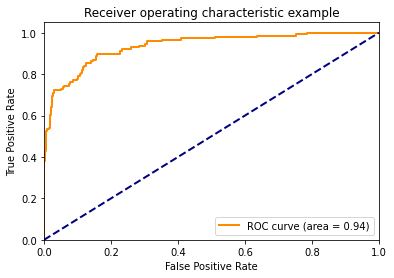

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp


# ylabel=label_binarize(y_testp,classes=[0,1])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
fpr, tpr, _ = roc_curve(y_testp, y_predit[:, 1])
roc_auc = auc(fpr, tpr)
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [ ]:
x_train[75].max()
dataset[0][3783]

0.0

In [ ]:
df[3783:3784]

,BID,PROTOCOL,LIGAND,PMODSUVR,ELIGVI1,ELIGVI2,CONSENSUS,SCORE,update_stamp
3783,B86670631,A4,Florbetapir,1.02,negative,NaN,NaN,negative,2021-03-29 11:38:41.0
